In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [3]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
186,8,181,68,36,495,30.1,0.615,60,1


# Step 0. Binarize the data

In [4]:
df_bin = pd.DataFrame()
#1
step = 8
col='Glucose'
start, finish = 40, 200
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['G('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#2
step = 5
col = 'BMI'
start, finish = 18, 67
df_bin[col[0]+'0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))


df_bin['Outcome'] = df['Outcome'] == 1



In [5]:
df_bin.shape

(768, 33)

In [6]:

df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,G=0,G(40;48],G(48;56],G(56;64],G(64;72],G(72;80],G(80;88],G(88;96],G(96;104],G(104;112],...,B(23;28],B(28;33],B(33;38],B(38;43],B(43;48],B(48;53],B(53;58],B(58;63],B(63;68],Outcome
id,,,,,,,,,,,,,,,,,,,,,
h511,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Split the data to train and test

In [7]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()



,G=0,G(40;48],G(48;56],G(56;64],G(64;72],G(72;80],G(80;88],G(88;96],G(96;104],G(104;112],...,B(18;23],B(23;28],B(28;33],B(33;38],B(38;43],B(43;48],B(48;53],B(53;58],B(58;63],B(63;68]
id,,,,,,,,,,,,,,,,,,,,,
h627,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [8]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 6.84 ms, sys: 0 ns, total: 6.84 ms
Wall time: 6.95 ms


FormalContext (537 objects, 32 attributes, 1074 connections)
    |G=0|G(40;48]|G(48;56]|G(56;64]|G(64;72]|...|B(43;48]|B(48;53]|B(53;58]|B(58;63]|B(63;68]|
h580|   |        |        |        |        |...|        |        |        |        |        |
h418|   |        |        |        |        |...|        |        |        |        |        |
h764|   |        |        |        |        |...|        |        |        |        |        |
h363|   |        |        |        |        |...|        |        |        |        |        |
h757|   |        |        |        |        |...|        |        |        |        |        |
h636|   |        |        |        |        |...|        |        |        |        |        |
h155|   |        |        |        |        |...|        |       X|        |        |        |
h390|   |        |        |        |        |...|        |        |        |        |        |
h761|   |        |        |        |        |...|       X|        |        |        

In [9]:
%%time 

L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
len(L)

CPU times: user 1min 34s, sys: 405 ms, total: 1min 35s
Wall time: 1min 35s


100

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [10]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [12]:

n_concepts = 4
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [13]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [14]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [ ]:
set(X_train.columns)

In [15]:
descr = {'G(192;200]'}

traced = cn.trace_description(descr, include_targets=False)

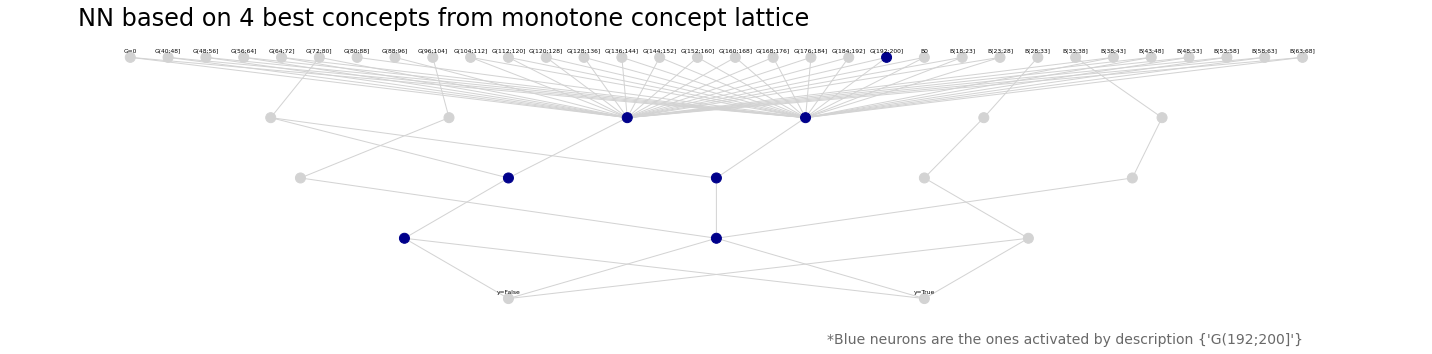

In [16]:
fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))
                ],
               node_size=100,
               node_label_font_size=6
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_g_b_gelu.png')
plt.show()

Now fit the network

In [18]:
import torch

In [19]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[2.20189011e-03 9.97798085e-01]
 [9.87168431e-01 1.28314951e-02]
 [9.98996675e-01 1.00337388e-03]
 [4.98365104e-01 5.01634836e-01]
 [9.99897838e-01 1.02108635e-04]
 [9.99990344e-01 9.67853430e-06]
 [1.38346001e-03 9.98616576e-01]
 [1.19776896e-03 9.98802185e-01]
 [9.99451101e-01 5.48945274e-04]
 [9.96641517e-01 3.35850916e-03]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5135135135135135
F1     score: 0.5671641791044775
Accuracy score: 0.7489177489177489


In [20]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 5000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 0 0 0 1 1 0 0]
Class prediction with probabilities [[1.2437963e-02 9.8756206e-01]
 [9.9955899e-01 4.4103194e-04]
 [1.0000000e+00 3.9648169e-09]
 [5.0376350e-01 4.9623653e-01]
 [1.0000000e+00 1.4463457e-10]
 [1.0000000e+00 1.5920213e-14]
 [2.5362758e-02 9.7463721e-01]
 [1.2864268e-02 9.8713571e-01]
 [1.0000000e+00 1.8211704e-08]
 [9.9998963e-01 1.0349961e-05]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.4594594594594595
F1     score: 0.5396825396825398
Accuracy score: 0.7489177489177489


In [21]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 10000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 0 0 0 1 1 0 0]
Class prediction with probabilities [[3.0704907e-08 1.0000000e+00]
 [9.9605089e-01 3.9491002e-03]
 [1.0000000e+00 3.1634293e-16]
 [5.0191349e-01 4.9808642e-01]
 [1.0000000e+00 4.1283464e-23]
 [1.0000000e+00 1.0938979e-17]
 [1.2869900e-07 9.9999988e-01]
 [1.7261638e-09 1.0000000e+00]
 [1.0000000e+00 1.3889371e-19]
 [9.9930894e-01 6.9110963e-04]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.4594594594594595
F1     score: 0.5396825396825398
Accuracy score: 0.7489177489177489


The best result were 2 000 epochs

In [30]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[6.6179344e-03 9.9338210e-01]
 [9.8011988e-01 1.9880114e-02]
 [9.9997532e-01 2.4646586e-05]
 [4.9256247e-01 5.0743747e-01]
 [9.9995315e-01 4.6809499e-05]
 [9.9953067e-01 4.6939112e-04]
 [1.0819955e-02 9.8918009e-01]
 [1.1100944e-02 9.8889905e-01]
 [9.9994433e-01 5.5711669e-05]
 [9.9041277e-01 9.5872683e-03]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5
F1     score: 0.5692307692307693
Accuracy score: 0.7575757575757576


In [31]:
edge_weights = cn.edge_weights_from_network()

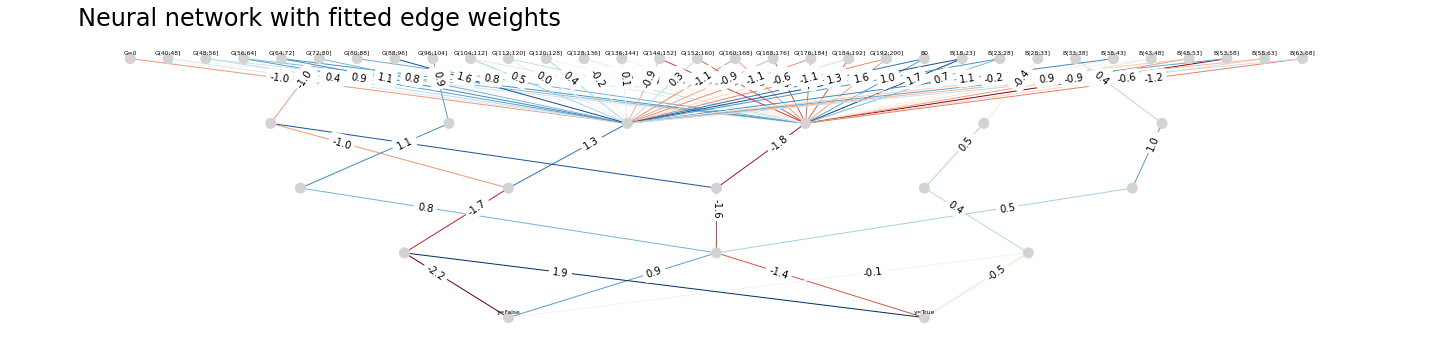

In [35]:
import networkx as nx

fig, ax = plt.subplots(figsize=(20,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
    
               node_size=100,
               node_label_font_size=6
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_g_b_gelu.png')
plt.show()